# Working run as starting point

In [2]:
# load external libs
import numpy as np
import matplotlib.pyplot as plt

# oggm modules
from oggm import utils, cfg, tasks, workflow, graphics
from oggm.core import flowline, massbalance, inversion, climate
from oggm.workflow import execute_entity_task

%matplotlib inline

## Initialisation

In [4]:
# specify the RGI ID for the Upper Grindelwald Glacier
rgi_id = 'RGI60-11.01270'

In [5]:
# Initialize OGGM and set up the run parameters
cfg.initialize()

# Local paths (where to write the OGGM run output)
wdir = 'mb_grindel_wd'
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir

# No need for intersects since this has an effect on the inversion only
cfg.PARAMS['use_intersects'] = True

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = False

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = False

# This used to be true but will change soon
cfg.PARAMS['filter_for_neg_flux'] = False

2018-11-27 15:13:26: oggm.cfg: Parameter file: /Users/oberrauch/oggm/oggm/params.cfg


Here I change the mass balance calibration parameters to better fitting values for the alpine region (see Matthias' blog post).

In [10]:
# change mass balance calibration params
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_all_liq'] = 2.0
cfg.PARAMS['temp_melt'] = -1.75
cfg.PARAMS['temp_default_gradient'] = -0.0065

# Set path to Histalp
cfg.PATHS['climate_file'] = 'raw_data/histalp_merged_full.nc'

In [11]:
# Get the RGI glaciers for the run
rgidf = utils.get_rgi_glacier_entities([rgi_id])

# We use intersects
db = utils.get_rgi_intersects_region_file(version='61', rgi_ids=[rgi_id])
cfg.set_intersects_db(db)

In [12]:
# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)

# Go - initialize working directories
gdirs = workflow.init_glacier_regions(rgidf)

# Prepro tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
]
# execute all tasks
for task in task_list:
    execute_entity_task(task, gdirs)

# Climate tasks
execute_entity_task(tasks.process_custom_climate_data, gdirs)

2018-11-27 15:15:32: oggm.core.gis: (RGI60-11.01270) glacier_masks
2018-11-27 15:15:32: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2018-11-27 15:15:32: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2018-11-27 15:15:32: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2018-11-27 15:15:34: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2018-11-27 15:15:35: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2018-11-27 15:15:36: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2018-11-27 15:15:36: oggm.core.climate: (RGI60-11.01270) process_custom_climate_data
2018-11-27 15:15:36: oggm.core.climate: OSError occurred during task process_custom_climate_data on RGI60-11.01270: Custom climate file not found


RuntimeError: (RGI60-11.01270) exception occured while processing task process_custom_climate_data: Custom climate file not found

In [9]:
gdir = gdirs[0]

In [23]:
tasks.mu_candidates(gdir)

2018-08-02 16:31:56: oggm.core.climate: (RGI60-11.01270) mu_candidates


In [24]:
mc = gdir.read_pickle('mu_candidates')

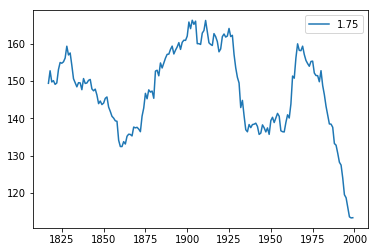

In [26]:
mc.plot();

In [29]:
mc.loc[[1903, 1975]]

,1.75
1903,166.315711
1975,155.350601


In [31]:
tasks.local_mustar(gdir, tstar=1903, prcp_fac=1.75, bias=0)

2018-08-02 16:37:25: oggm.core.climate: (RGI60-11.01270) local_mustar
2018-08-02 16:37:25: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1903
